In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
import time
import xgboost as xgb

In [2]:
df = pd.read_pickle("df_location.pkl")
number_of_houses = len(df.columns)
df.reset_index(drop=True, inplace=True)
df

,Time,Energy,Location
0,2019-01-01 00:00:00,2.964000,0
1,2019-01-01 00:15:00,2.584000,0
2,2019-01-01 00:30:00,3.071000,0
3,2019-01-01 00:45:00,2.694000,0
4,2019-01-01 01:00:00,2.569000,0
...,...,...,...
1791931,2020-01-01 22:45:00,0.753222,50
1791932,2020-01-01 23:00:00,0.716855,50
1791933,2020-01-01 23:15:00,0.735802,50
1791934,2020-01-01 23:30:00,0.485237,50


### Auxiliary functions

In [11]:
def plot_results(preds: np.array, actuals: np.array, title: str):
    
    plt.scatter(actuals, preds, c='b', label='predicted')
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title(title)
    plt.xlim(0, plt.xlim()[1])
    plt.ylim(0, plt.ylim()[1])
    _ = plt.plot([0, 100], [0, 100], '--r', label='y=x')
    plt.legend()
    plt.show()
    
    
def performance_metrics(preds: np.array, actuals: np.array):

    # calculate performance metrics
    
    mse = mean_squared_error(actuals, preds)
    mae = mean_absolute_error(actuals, preds)
    rmse = np.sqrt(mse)
    #print("wape test:",np.sum(np.abs(preds - actuals)) / np.sum(np.abs(actuals)) * 100)
    wape = mae / actuals.mean() * 100
    r2 = r2_score(actuals, preds)

    # print performance metrics
    print('MSE: %.4f' % mse)
    print('RMSE: %.4f' % rmse)
    print('MAE: %.4f' % mae)
    #print('MAPE: %.4f' % mape)
    print('WAPE: %.4f' % wape)
    print('R2: %.4f' % r2)
    return mse, rmse, mae, wape, r2

#@jit(target_backend='cuda')
def build_model(estimator, X_train: np.array, y_train: np.array, X_test: np.array):
    
    model = estimator
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    return model, preds

def validate(estimator, X_train, y_train):
    scores = cross_validate(estimator, X_train, y_train, scoring=['r2', 'neg_root_mean_squared_error', 'neg_mean_squared_error', 'neg_mean_absolute_error'])
    return scores
    

NameError: name 'jit' is not defined

In [13]:
def total_averaged_metrics(metrics_list):
    
    print("Total Averaged MSE: {}".format(np.round(sum(i for i, j, k, l, m in metrics_list)/len(metrics_list),3)))
    print("Total Averaged RMSE: {}".format(np.round(sum(j for i, j, k, l, m in metrics_list)/len(metrics_list),3)))
    print("Total Averaged MAE: {}".format(np.round(sum(k for i, j, k, l, m in metrics_list)/len(metrics_list),3)))
    print("Total Averaged WAPE: {}".format(np.round(sum(l for i, j, k, l, m in metrics_list)/len(metrics_list),3)))
    print("Total Averaged R2: {}".format(np.round(sum(m for i, j, k, l, m in metrics_list)/len(metrics_list),3)))


def last_energy_points(df, number_timesteps):
    X = pd.DataFrame()
    for i in range(1, (number_timesteps + 1) ):
        X[f'Energy_{i*15}'] = df['Energy'].shift(i)
    X.dropna(inplace=True)
    X.reset_index(drop=True, inplace=True)
    y = pd.DataFrame(df[number_timesteps:])
    y = y['Energy']
    y.reset_index(drop=True, inplace=True)
    y.columns = ["Energy"]
    return X, y

def build_predict_show(df, number_timesteps, estimator, normalize=False, train_size=0.8, start_timestep=1 ):
    full_start = time.time()
    metrics_list = []
    for i in range(start_timestep,(number_timesteps + 1)):
        start = time.time()
        print("\nIteration ", i)
        X, y = last_energy_points(df, i)

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)
        if(normalize):
            scaler = MinMaxScaler().fit(X_train)
            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)
        model, preds, scores = build_model(estimator, X_train, y_train, X_test)
        mse, rmse, mae, mape, r2 = performance_metrics(preds, y_test.values.reshape(-1))
        cv_mse = np.round(scores['test_neg_mean_squared_error'].mean() * (-1),4)
        cv_rmse = np.round(scores['test_neg_root_mean_squared_error'].mean() * (-1),4)
        cv_mae = np.round(scores['test_neg_mean_absolute_error'].mean() * (-1),4)
        cv_r2 = np.round(scores['test_r2'].mean(),5)
        #print("CV MSE: {} ".format(cv_mse))
        #print("CV RMSE: {} ".format(cv_rmse))
        #print("CV MAE: {} ".format(cv_mae))
        #print("CV R2: {} ".format(cv_r2))
        print("CV MSE: {} ".format(scores['test_neg_mean_squared_error']))
        print("CV RMSE: {} ".format(scores['test_neg_root_mean_squared_error']))
        print("CV MAE: {} ".format(scores['test_neg_mean_absolute_error']))
        print("CV R2: {} ".format(scores['test_r2']))
        metrics_list.append((cv_mse,cv_rmse,cv_mae,mape,cv_r2))
        print("\nElapsed time: %.3f seconds" % (time.time() - start))
    print("\nFull Elapsed time: %.3f seconds" % (time.time() - full_start))
    return model, preds, scores, metrics_list

def split_train_test_timeseries(X, y, train_size: int):
    n_train_samples = int(len(X) * train_size)
    X_train = X[:n_train_samples]
    X_test = X[n_train_samples:]
    y_train = y[:n_train_samples]
    y_test = y[n_train_samples:]
    return X_train, X_test, y_train, y_test

def show_graphic_per_timestep(metrics_list, number_timesteps, start_timestep=1):
    mse_list = []
    rmse_list = []
    mae_list = []
    wape_list = []
    r2_list = []

    for i in range(0,len(metrics_list)):
        mse_list.append(metrics_list[i][0])
        rmse_list.append(metrics_list[i][1])
        mae_list.append(metrics_list[i][2])
        wape_list.append(metrics_list[i][3])
        r2_list.append(metrics_list[i][4])
        
    plt.plot(range(start_timestep,(number_timesteps+1)), mse_list)
    plt.title('MSE per past timestep')
    plt.xlabel('Number of past timesteps')
    plt.ylabel('MSE')
    plt.show()
    
    plt.plot(range(start_timestep,(number_timesteps+1)), rmse_list)
    plt.title('RMSE per past timestep')
    plt.xlabel('Number of past timesteps')
    plt.ylabel('RMSE')
    plt.show()
    
    plt.plot(range(start_timestep,(number_timesteps+1)), mae_list)
    plt.title('MAE per past timestep')
    plt.xlabel('Number of past timesteps')
    plt.ylabel('MAE')
    plt.show()
    
    plt.plot(range(start_timestep,(number_timesteps+1)), wape_list)
    plt.title('WAPE per past timestep')
    plt.xlabel('Number of past timesteps')
    plt.ylabel('WAPE')
    plt.show()
    
    plt.plot(range(start_timestep,(number_timesteps+1)), r2_list)
    plt.title('R2 per past timestep')
    plt.xlabel('Number of past timesteps')
    plt.ylabel('R2')
    plt.show()
    

## Preprocessing

In [14]:
X,y = last_energy_points(df, 12)
print(X.shape, y.shape)
X

(1791924, 12) (1791924,)


,Energy_15,Energy_30,Energy_45,Energy_60,Energy_75,Energy_90,Energy_105,Energy_120,Energy_135,Energy_150,Energy_165,Energy_180
0,3.047000,2.553000,3.223000,2.994000,2.922000,2.558000,3.174000,2.569000,2.694000,3.071000,2.584000,2.964000
1,3.310000,3.047000,2.553000,3.223000,2.994000,2.922000,2.558000,3.174000,2.569000,2.694000,3.071000,2.584000
2,2.514000,3.310000,3.047000,2.553000,3.223000,2.994000,2.922000,2.558000,3.174000,2.569000,2.694000,3.071000
3,2.972000,2.514000,3.310000,3.047000,2.553000,3.223000,2.994000,2.922000,2.558000,3.174000,2.569000,2.694000
4,2.976000,2.972000,2.514000,3.310000,3.047000,2.553000,3.223000,2.994000,2.922000,2.558000,3.174000,2.569000
...,...,...,...,...,...,...,...,...,...,...,...,...
1791919,1.099100,0.453906,0.481770,0.483173,0.467528,1.001887,0.552398,0.533286,0.533451,0.464143,0.552398,0.937120
1791920,0.753222,1.099100,0.453906,0.481770,0.483173,0.467528,1.001887,0.552398,0.533286,0.533451,0.464143,0.552398
1791921,0.716855,0.753222,1.099100,0.453906,0.481770,0.483173,0.467528,1.001887,0.552398,0.533286,0.533451,0.464143
1791922,0.735802,0.716855,0.753222,1.099100,0.453906,0.481770,0.483173,0.467528,1.001887,0.552398,0.533286,0.533451


In [15]:
y

0          3.310000
1          2.514000
2          2.972000
3          2.976000
4          2.916000
             ...   
1791919    0.753222
1791920    0.716855
1791921    0.735802
1791922    0.485237
1791923    0.394216
Name: Energy, Length: 1791924, dtype: float64

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1433539, 12), (358385, 12), (1433539,), (358385,))

In [17]:
start = time.time()
model, preds = build_model(xgb.XGBRegressor(seed=0), X_train, y_train, X_test)
print("\nElapsed time: %.3f seconds" % (time.time() - start))


Elapsed time: 141.756 seconds


In [18]:
metrics_list = []
mse, rmse, mae, mape, r2 = performance_metrics(preds, y_test.values.reshape(-1))

MSE: 0.1787
RMSE: 0.4227
MAE: 0.2097
WAPE: 27.4302
R2: 0.8520


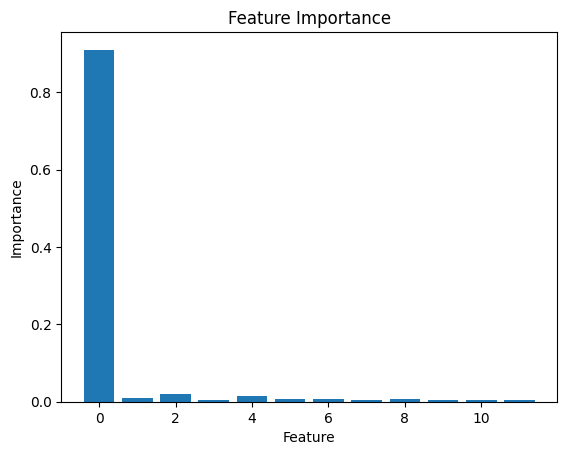

In [19]:
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [20]:
scores = validate(model, X_train, y_train)
cv_mse = np.round(scores['test_neg_mean_squared_error'].mean() * (-1),4)
cv_rmse = np.round(scores['test_neg_root_mean_squared_error'].mean() * (-1),4)
cv_mae = np.round(scores['test_neg_mean_absolute_error'].mean() * (-1),4)
cv_r2 = np.round(scores['test_r2'].mean(),5)
print("CV MSE: {} ".format(cv_mse))
print("CV RMSE: {} ".format(cv_rmse))
print("CV MAE: {} ".format(cv_mae))
print("CV R2: {} ".format(cv_r2))
metrics_list.append((cv_mse,cv_rmse,cv_mae,mape,cv_r2))

CV MSE: 0.1814 
CV RMSE: 0.4259 
CV MAE: 0.2101 
CV R2: 0.84424 


In [21]:
locations = np.random.choice(df['Location'].unique(), size=10, replace=False)
locations

array([48, 12, 16, 18, 35, 36, 29,  1, 47, 25])

In [22]:
test = df[df['Location'].isin(locations)]
# remove the houses from the training set
train = df[~df['Location'].isin(locations)]
X_train, X_test = pd.DataFrame(), pd.DataFrame()
for i in range(1, 5):
    X_train[f'Energy_{i*15}'] = train['Energy'].shift(i)
    X_test[f'Energy_{i*15}'] = test['Energy'].shift(i)
y_train = train['Energy']
y_train = y_train[4:].reset_index(drop=True)
X_train = X_train[4:].reset_index(drop=True)
X_test = X_test[4:].reset_index(drop=True)
y_test = test['Energy']
y_test = y_test[4:].reset_index(drop=True)

model = xgb.XGBRegressor(seed=0)
init = time.time()
model.fit(X_train, y_train)
end = time.time()

print('Training time: {:.4f} s'.format(end - init))

init = time.time()
y_pred = model.predict(X_test)
end = time.time()
mse, rmse, mae, mape, r2 = performance_metrics(y_pred, y_test.values.reshape(-1))

Training time: 50.6612 s
MSE: 0.2040
RMSE: 0.4517
MAE: 0.2248
WAPE: 30.3801
R2: 0.7475


In [23]:
start = time.time()
model_lr, preds_lr, scores_lr = build_model(LinearRegression(), X_train, y_train, X_test)
print("\nElapsed time: %.3f seconds" % (time.time() - start))

ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
metrics_list_lr = []
mse, rmse, mae, mape, r2 = performance_metrics(preds_lr, y_test.values.reshape(-1))
cv_mse = np.round(scores_lr['test_neg_mean_squared_error'].mean() * (-1),4)
cv_rmse = np.round(scores_lr['test_neg_root_mean_squared_error'].mean() * (-1),4)
cv_mae = np.round(scores_lr['test_neg_mean_absolute_error'].mean() * (-1),4)
cv_r2 = np.round(scores_lr['test_r2'].mean(),5)
print("CV MSE: {} ".format(cv_mse))
print("CV RMSE: {} ".format(cv_rmse))
print("CV MAE: {} ".format(cv_mae))
print("CV R2: {} ".format(cv_r2))
metrics_list_lr.append((cv_mse,cv_rmse,cv_mae,mape,cv_r2))

## Test model

In [ ]:
start_timestep = 4
number_timesteps = 12

## XGBoost

In [ ]:
model_xgb, preds_xgb, scores_xgb, metrics_list_xgb = build_predict_show(df, number_timesteps, xgb.XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=100, seed=42), start_timestep=start_timestep)

In [ ]:
show_graphic_per_timestep(metrics_list_xgb, number_timesteps, start_timestep=start_timestep)

In [ ]:
print(min([sublist[3] for sublist in metrics_list_gb]))
print(min([sublist[3] for sublist in metrics_list_rf]))
print(min([sublist[3] for sublist in metrics_list_xgb]))

In [ ]:
def switch_metric(metric: str):
    if metric.lower() == "mse":
        m = 0
    elif metric.lower() == "rmse":
        m = 1
    elif metric.lower() == "mae":
        m = 2
    elif metric.lower() == "wape":
        m = 3
    elif metric.lower() == "r2":
        m = 4
    return m

In [ ]:
def find_best_model(metric: str, metrics_list):
    met = switch_metric(metric)
    min_value = min(map(lambda x: x[met], metrics_list))
    idx = [index for index, item in enumerate(map(lambda x: x[met], metrics_list)) if item == min_value]
    return metrics_list[idx[0]]

In [ ]:
all_metrics_lists = [metrics_list_gb, metrics_list_rf, metrics_list_xgb]

In [ ]:
best_model = []
for model in all_metrics_lists:
    best_model.append(find_best_model("wape", model))

### Plot Best models

In [ ]:
X_names = ("WAPE", "R2")
X_axis = np.arange(len(X_names))
plt.bar(X_axis - 0.2, (best_model[0][3] / 100, best_model[0][4]), 0.2, label = 'GB')
plt.bar(X_axis, (best_model[1][3] / 100, best_model[1][4]), 0.2, label = 'RF')
plt.bar(X_axis + 0.2, (best_model[2][3] / 100, best_model[2][4]), 0.2, label = 'XGB')
plt.ylim(0,1)
plt.xticks(X_axis, X_names)
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.title("Comparison between GB, RF and XGB")
plt.legend()
plt.show()